## Parity Plot

Combine individual parity plots into one large figure containing all parity plots for every operator

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from plot_methods import get_parity_data, make_parity_plot


cm_1_data, cm_1_notes = get_parity_data('Carbon Mapper', stage = 1)
cm_2_data, cm_2_notes = get_parity_data('Carbon Mapper', stage = 2)
cm_3_data, cm_3_notes = get_parity_data('Carbon Mapper', stage = 3)
ghg_1_data, ghg_1_notes = get_parity_data('GHGSat', stage = 1)
ghg_2_data, ghg_2_notes = get_parity_data('GHGSat', stage = 2)
ghg_3_data, ghg_3_notes = get_parity_data('GHGSat', stage = 3)
kairos_1_data, kairos_1_notes = get_parity_data('Kairos', stage=1)
kairos_2_data, kairos_2_notes = get_parity_data('Kairos', stage=2)
kairos_3_data, kairos_3_notes = get_parity_data('Kairos', stage=3)
mair_1_data, mair_1_notes = get_parity_data('Methane Air', stage=1)
sciav_1_data, sciav_1_notes = get_parity_data('Scientific Aviation', stage=1, strict_discard=True)

fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])
axes_max = 2300
# Carbon Mapper
ax1 = make_parity_plot(cm_1_data, cm_1_notes, ax1, [0, axes_max])
ax2 = make_parity_plot(cm_2_data, cm_2_notes, ax2, [0, axes_max])
ax3 = make_parity_plot(cm_3_data, cm_3_notes, ax3, [0, axes_max])

print('Making GHGSat plots...')
# GHGSat
ax4 = make_parity_plot(ghg_1_data, ghg_1_notes, ax4, [0, axes_max])
ax5 = make_parity_plot(ghg_2_data, ghg_2_notes, ax5, [0, axes_max])
ax6 = make_parity_plot(ghg_3_data, ghg_3_notes, ax6, [0, axes_max])

print('Making Kairos plots...')
# Kairos
ax7 = make_parity_plot(kairos_1_data, kairos_1_notes, ax7, [0, axes_max])
ax8 = make_parity_plot(kairos_2_data, kairos_2_notes, ax8, [0, axes_max])
ax9 = make_parity_plot(kairos_3_data, kairos_3_notes, ax9, [0, axes_max])

# MethaneAIR
print('Making MethaneAIR plots...')

ax10 = make_parity_plot(mair_1_data, mair_1_notes, ax10, [0, axes_max])

# Scientific Aviation
ax11 = make_parity_plot(sciav_1_data, sciav_1_notes, ax11, [0, axes_max])

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_parity_{save_time}')
plt.savefig(save_path)
print('Figure saved')

Making GHGSat plots...
Making Kairos plots...
Making MethaneAIR plots...
Figure saved


Figure saved


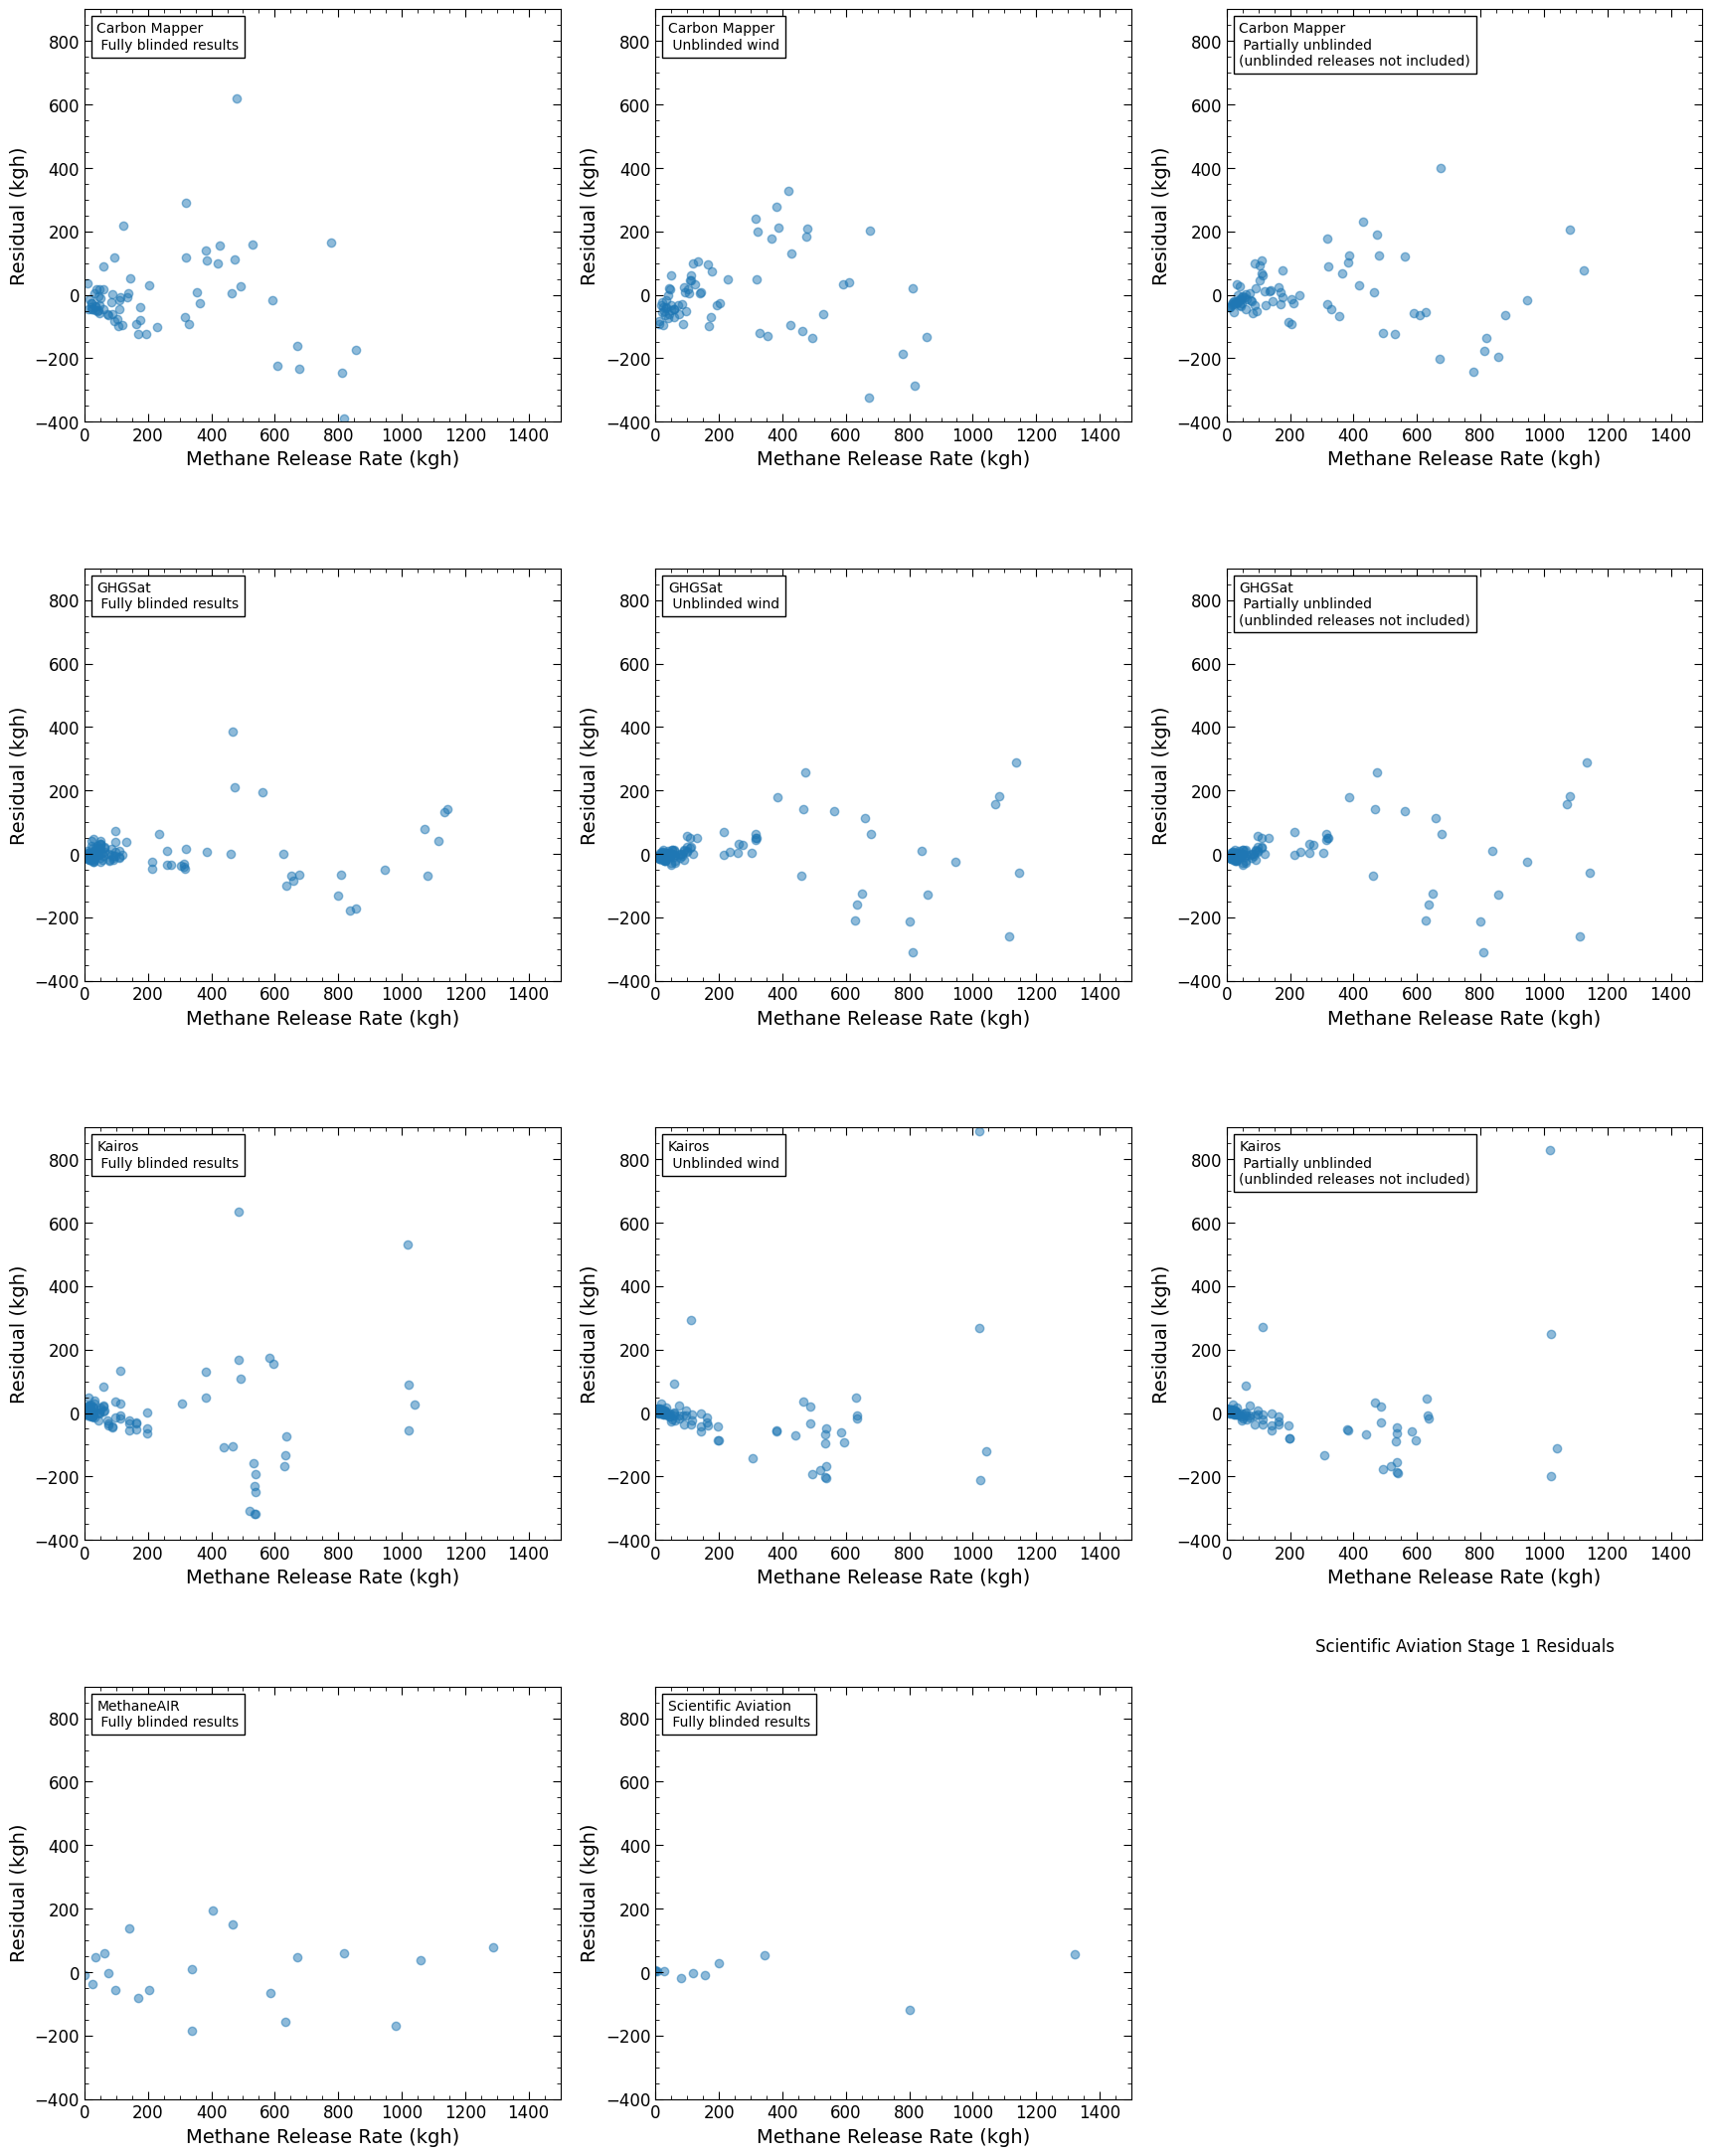

In [3]:
# Figure of all residuals
from plot_methods import plot_residuals
import matplotlib.pyplot as plt
import datetime
import pathlib

residual_ylim = [-400, 900]
residual_xlim = [0, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])


ax1 = plot_residuals(ax1, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_residuals(ax2, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_residuals(ax3, residual_xlim, residual_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_residuals(ax4, residual_xlim, residual_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_residuals(ax5, residual_xlim, residual_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_residuals(ax6, residual_xlim, residual_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_residuals(ax7, residual_xlim, residual_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_residuals(ax8, residual_xlim, residual_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_residuals(ax9, residual_xlim, residual_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_residuals(ax10, residual_xlim, residual_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_residuals(ax11, residual_xlim, residual_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all')

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_residuals_{save_time}')
plt.savefig(save_path)
print('Figure saved')


Figure saved


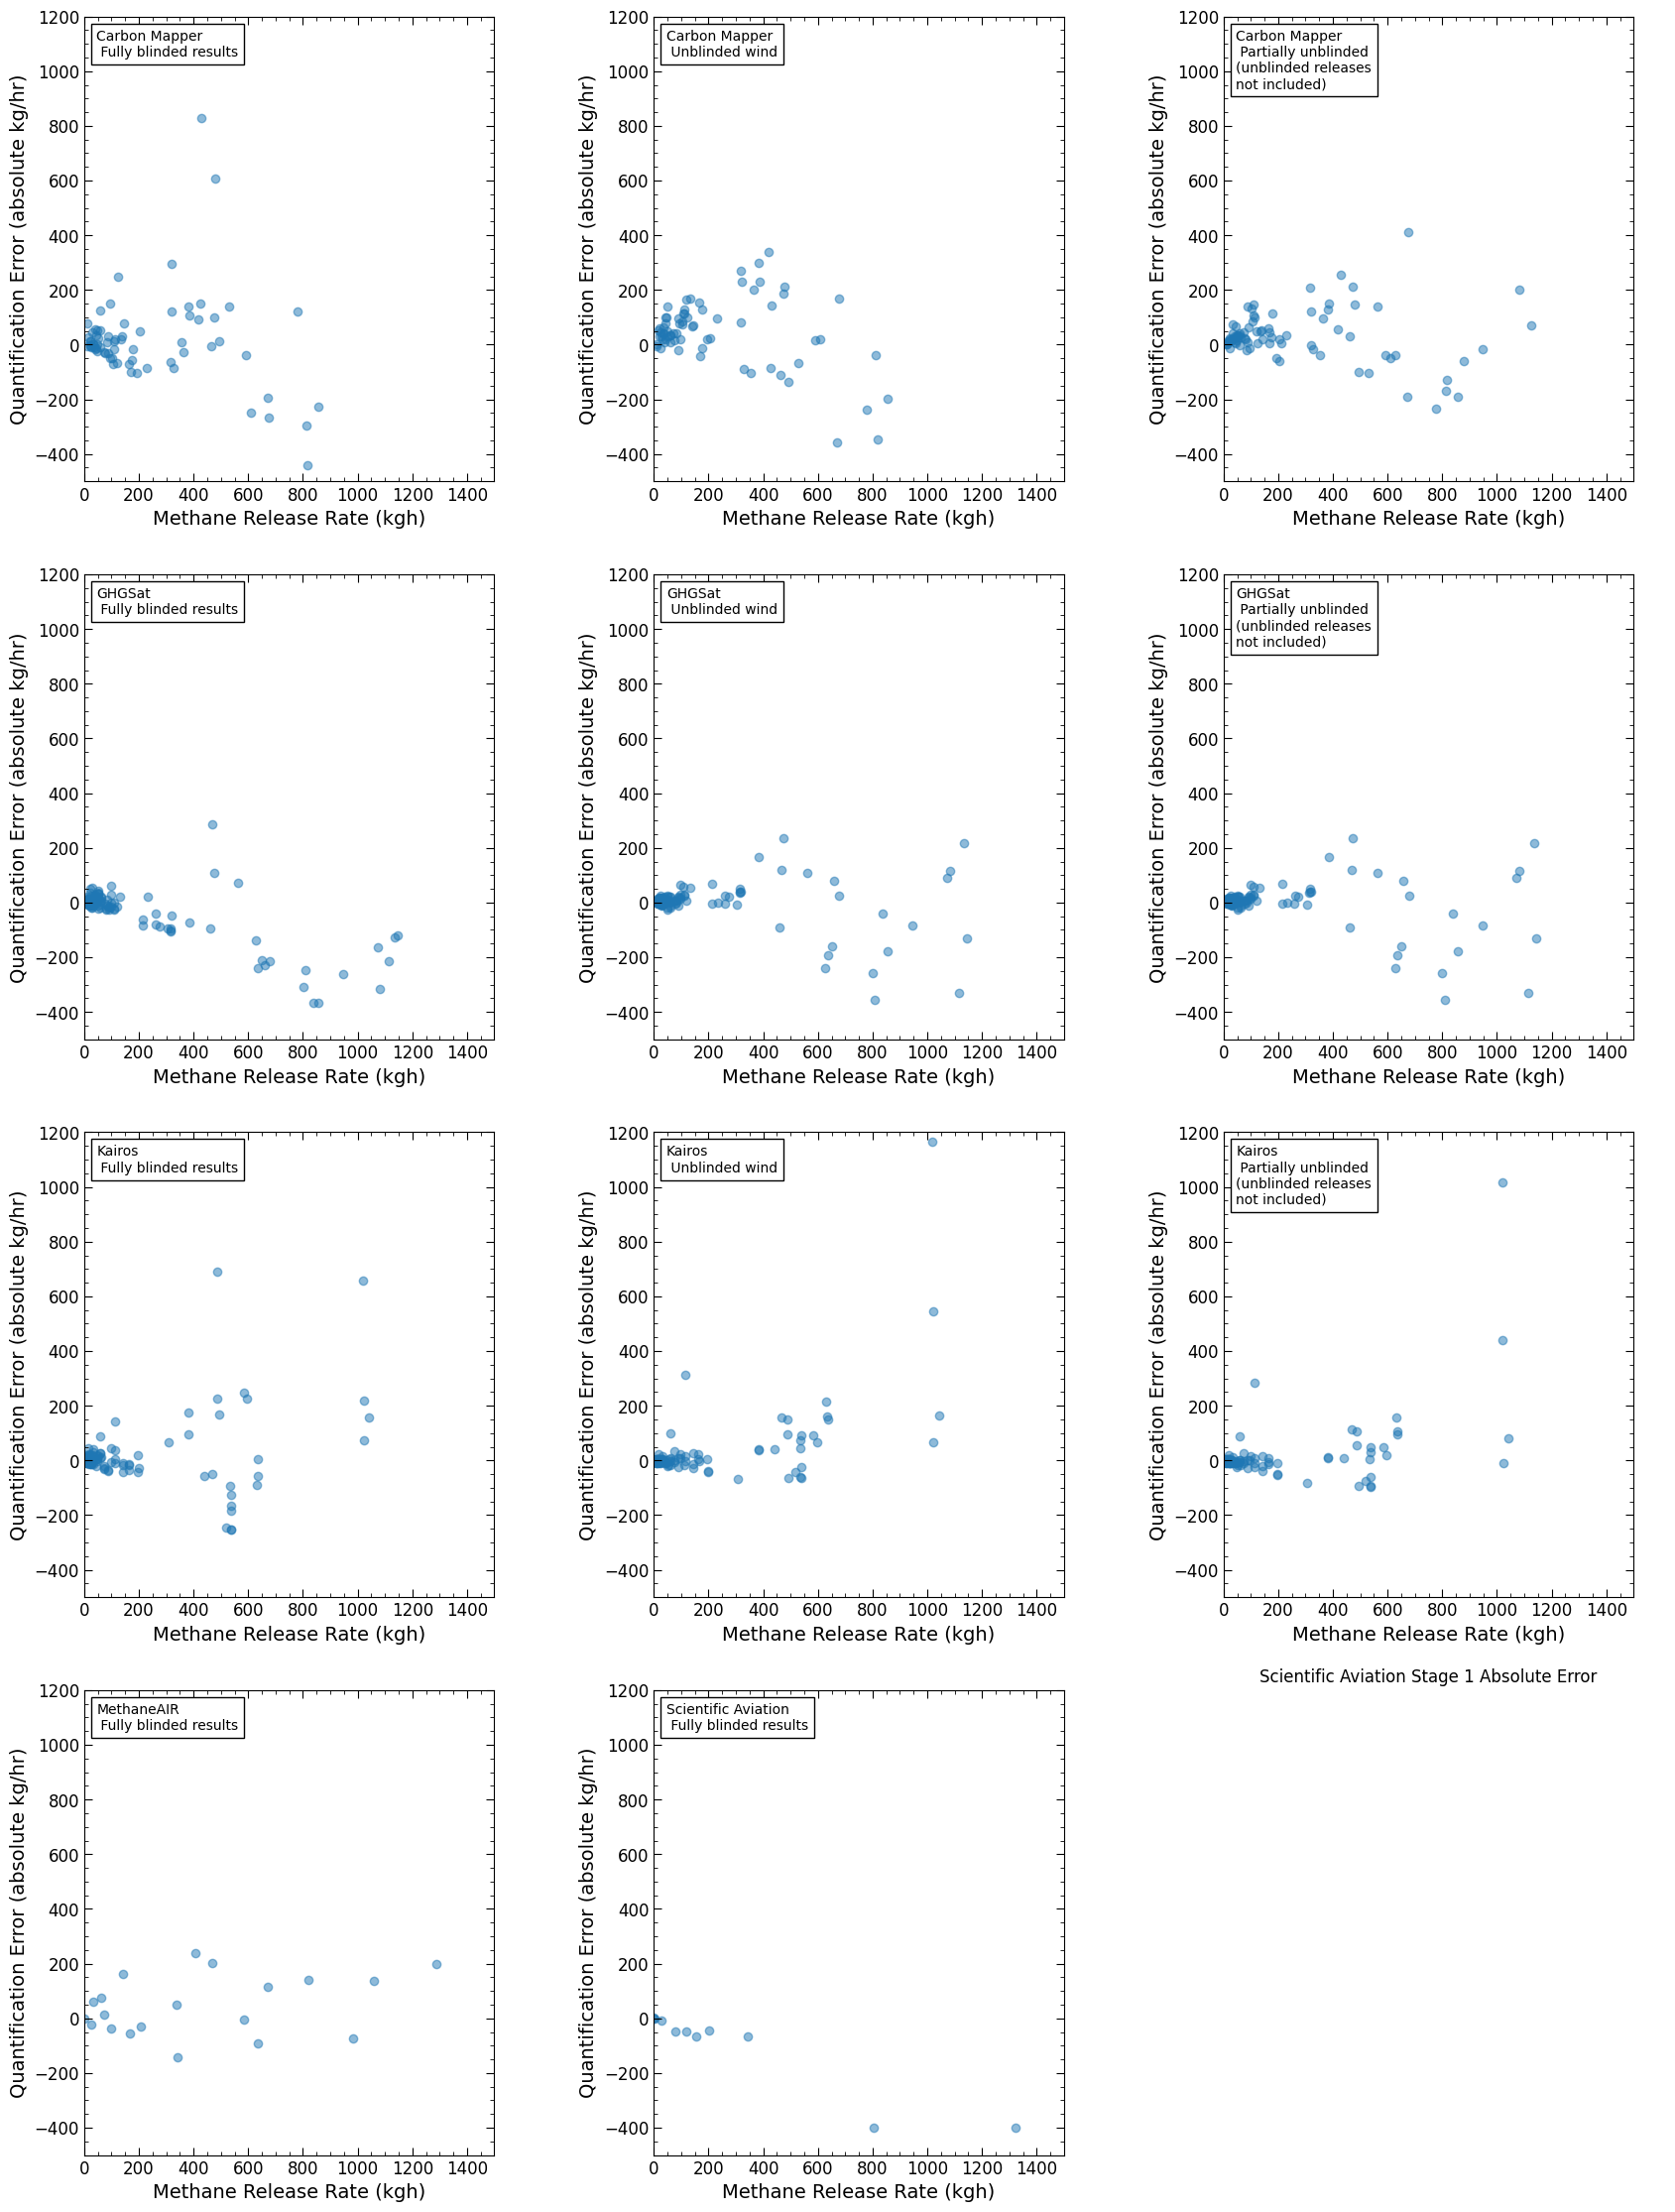

In [6]:
# Figure of all absolute error
from plot_methods import plot_quant_error_absolute
import matplotlib.pyplot as plt
import datetime
import pathlib

absolute_ylim = [-500, 1200]
absolute_xlim = [0, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])


ax1 = plot_quant_error_absolute(ax1, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_quant_error_absolute(ax2, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_quant_error_absolute(ax3, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_quant_error_absolute(ax4, absolute_xlim, absolute_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_quant_error_absolute(ax5, absolute_xlim, absolute_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_quant_error_absolute(ax6, absolute_xlim, absolute_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_quant_error_absolute(ax7, absolute_xlim, absolute_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_quant_error_absolute(ax8, absolute_xlim, absolute_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_quant_error_absolute(ax9, absolute_xlim, absolute_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_quant_error_absolute(ax10, absolute_xlim, absolute_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_quant_error_absolute(ax11, absolute_xlim, absolute_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all')

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_error_absolute_{save_time}')
plt.savefig(save_path)
print('Figure saved')

Figure saved


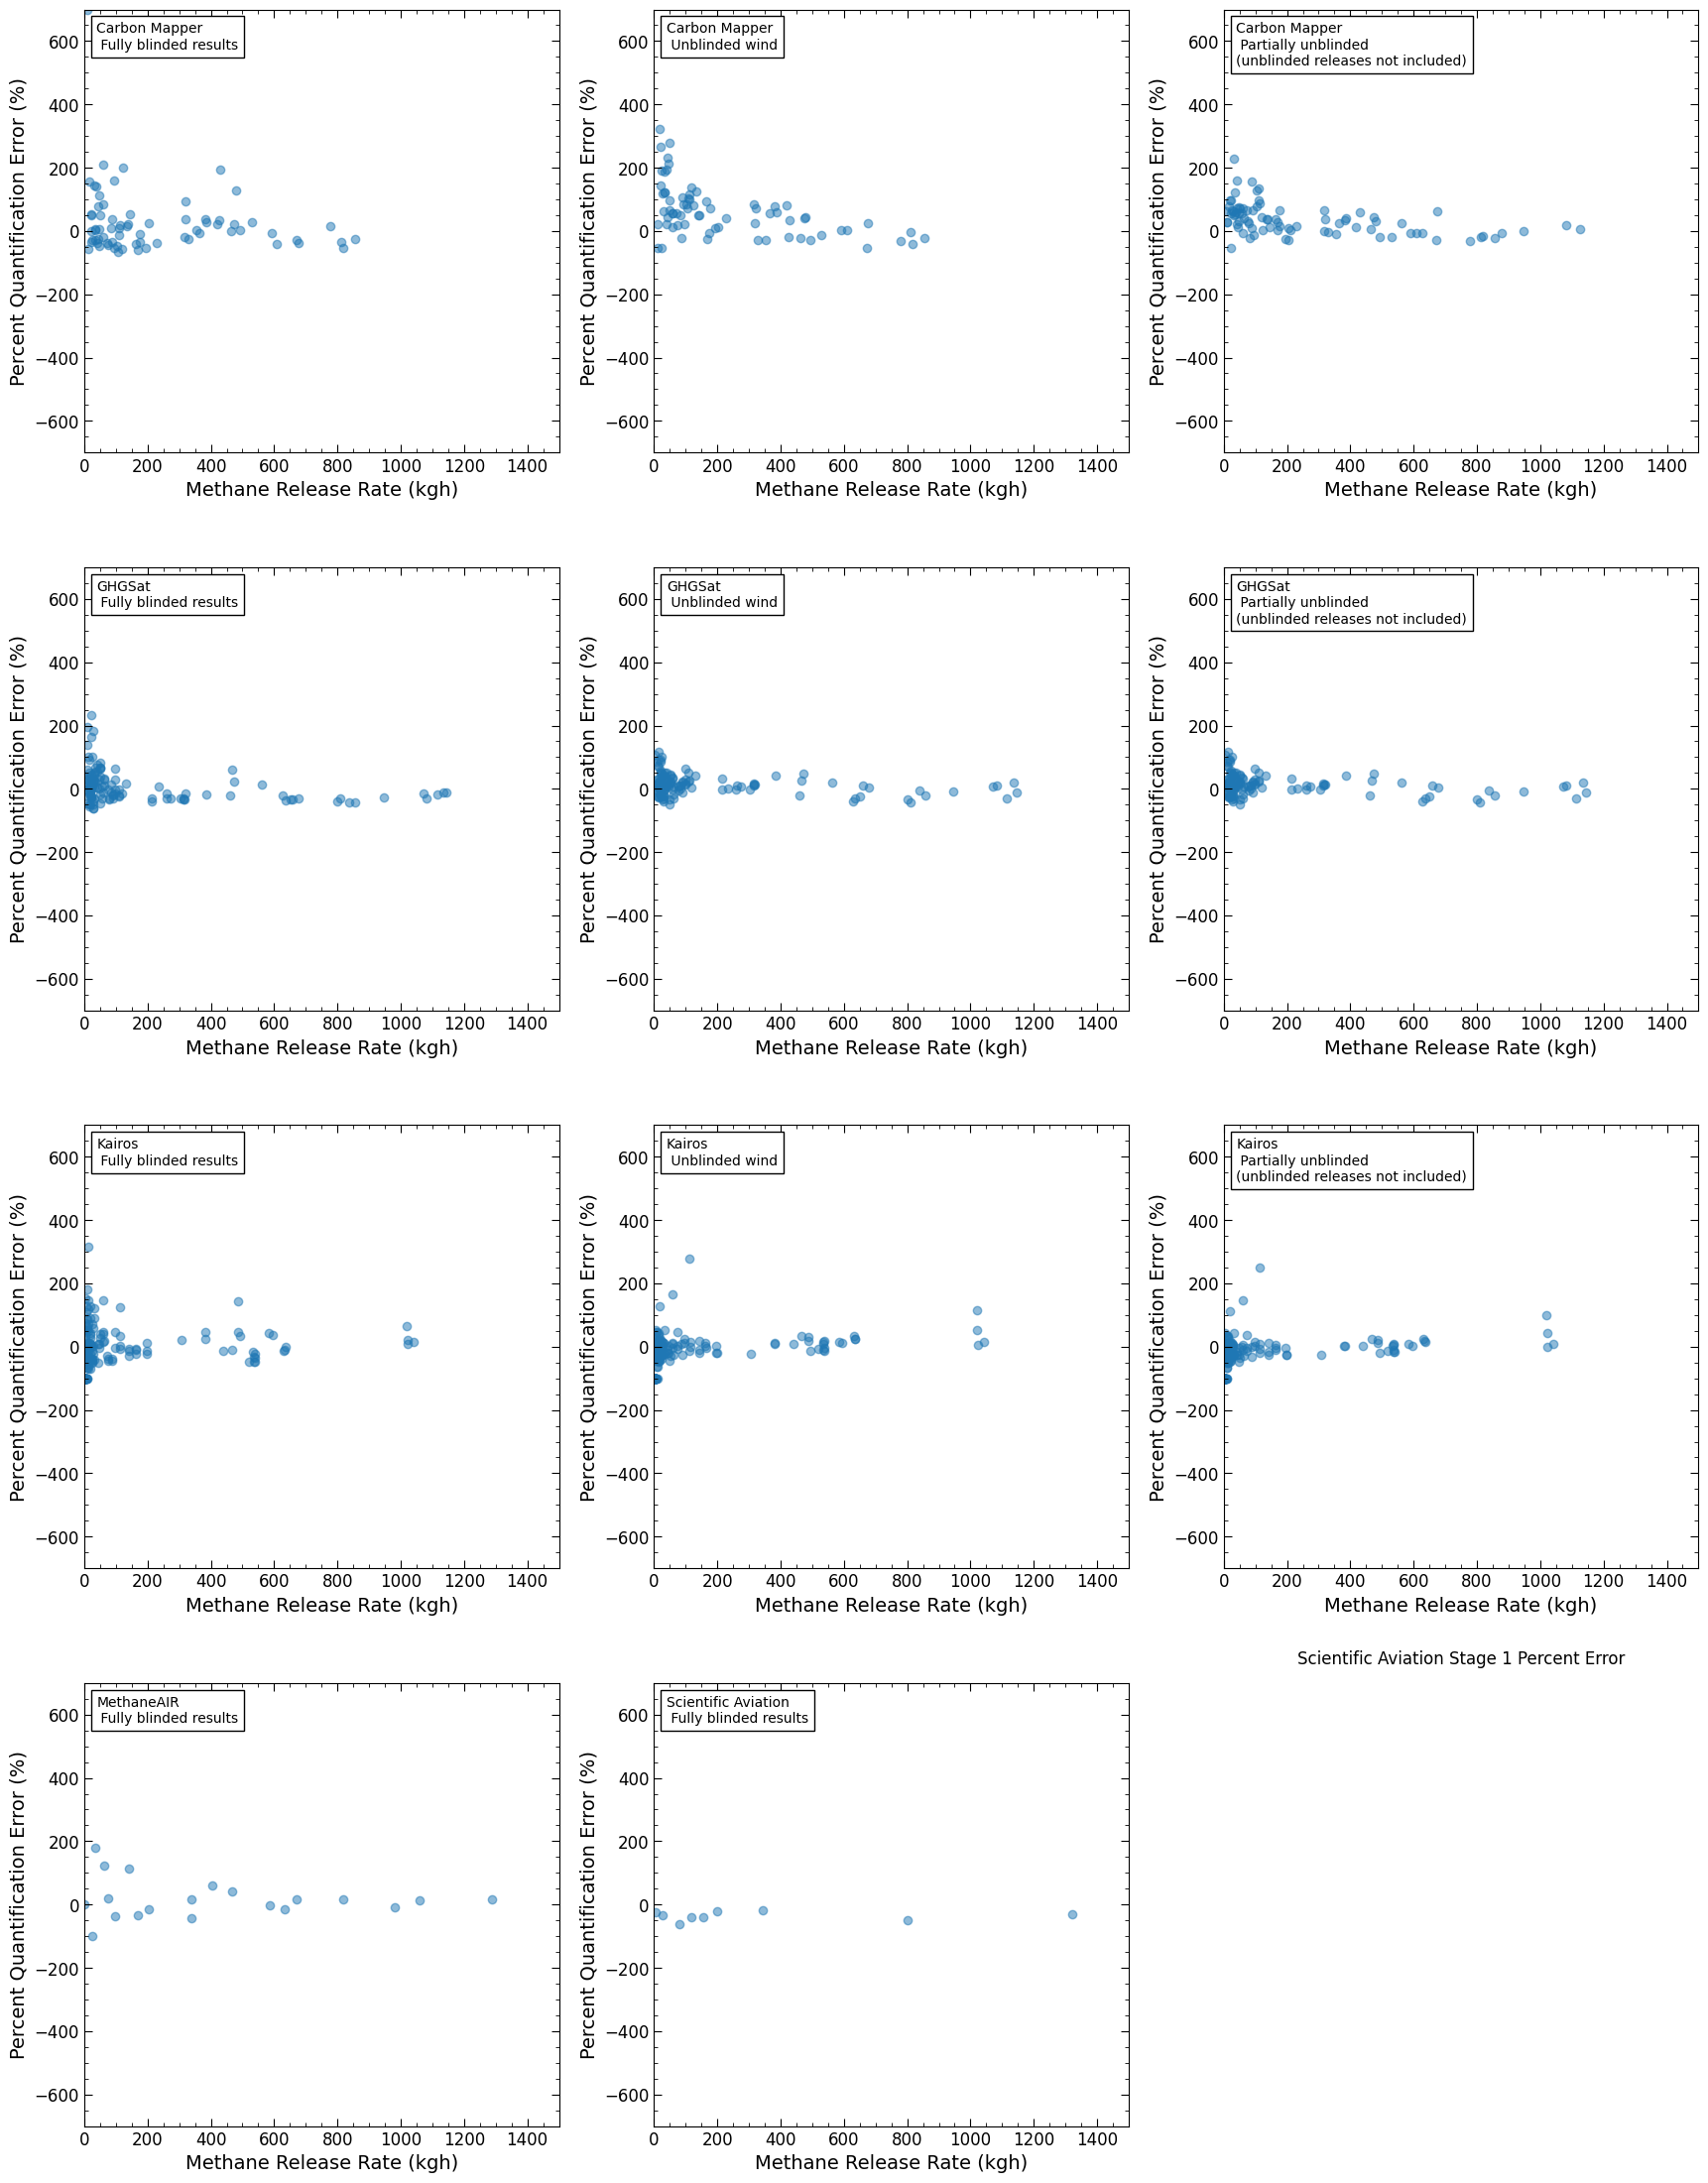

In [4]:
# Figure of all percent error
from plot_methods import plot_quant_error_percent
import matplotlib.pyplot as plt
import datetime
import pathlib

absolute_ylim = [-700, 700]
absolute_xlim = [0, 1500]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])


ax1 = plot_quant_error_percent(ax1, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=1, qc_status='pass_all')
ax2= plot_quant_error_percent(ax2, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=2, qc_status='pass_all')
ax3= plot_quant_error_percent(ax3, absolute_xlim, absolute_ylim, operator='Carbon Mapper', stage=3, qc_status='pass_all')
ax4= plot_quant_error_percent(ax4, absolute_xlim, absolute_ylim, operator='GHGSat', stage=1, qc_status='pass_all')
ax5= plot_quant_error_percent(ax5, absolute_xlim, absolute_ylim, operator='GHGSat', stage=2, qc_status='pass_all')
ax6= plot_quant_error_percent(ax6, absolute_xlim, absolute_ylim, operator='GHGSat', stage=3, qc_status='pass_all')
ax7= plot_quant_error_percent(ax7, absolute_xlim, absolute_ylim, operator='Kairos', stage=1, qc_status='pass_all')
ax8= plot_quant_error_percent(ax8, absolute_xlim, absolute_ylim, operator='Kairos', stage=2, qc_status='pass_all')
ax9= plot_quant_error_percent(ax9, absolute_xlim, absolute_ylim, operator='Kairos', stage=3, qc_status='pass_all')
ax10= plot_quant_error_percent(ax10, absolute_xlim, absolute_ylim, operator='MethaneAIR', stage=1, qc_status='pass_all')
ax11= plot_quant_error_percent(ax11, absolute_xlim, absolute_ylim, operator='Scientific Aviation', stage=1, qc_status='pass_all')

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_error_percent_{save_time}')
plt.savefig(save_path)
print('Figure saved')